In [2]:
import pandas as pd
from snownlp import SnowNLP
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm # 用于显示进度条

In [3]:
# --- 配置参数 ---
# 使用原始字符串或双反斜杠来处理 Windows 路径
FILE_PATH = r"D:\GitHubRepos\is6941-ml-social-media\taptap\data\integrated\lm_cleaned_taptap_reviews.csv"
TEXT_COLUMN = 'review_content' # 包含评论文本的列名
LABEL_COLUMN = 'sentiment'    # 包含真实情感标签 (0 或 1) 的列名
TEST_SIZE = 0.2               # 测试集所占比例 (例如 20%)
RANDOM_STATE = 42             # 随机种子，确保每次划分结果一致
SENTIMENT_THRESHOLD = 0.5     # SnowNLP 得分阈值，大于等于此值为正面 (1)，否则为负面 (0)

In [4]:
# --- 1. 加载数据 ---
print(f"正在加载数据: {FILE_PATH}")
try:
    df = pd.read_csv(FILE_PATH)
    print(f"数据加载完成. 数据形状: {df.shape}")
    # 显示前几行和列信息，检查是否加载正确
    # print(df.head())
    # print(df.info())
except FileNotFoundError:
    print(f"错误: 文件未找到 {FILE_PATH}")
    exit()
except Exception as e:
    print(f"加载 CSV 时出错: {e}")
    exit()

正在加载数据: D:\GitHubRepos\is6941-ml-social-media\taptap\data\integrated\lm_cleaned_taptap_reviews.csv
数据加载完成. 数据形状: (39985, 9)


In [5]:
# --- 2. 数据准备 ---
print("准备数据 (选择列，处理缺失值)...")
# 选择需要的列，并创建副本以避免 SettingWithCopyWarning
df_processed = df[[TEXT_COLUMN, LABEL_COLUMN]].copy()

# 删除包含缺失评论或缺失标签的行
initial_rows = len(df_processed)
df_processed.dropna(subset=[TEXT_COLUMN, LABEL_COLUMN], inplace=True)
rows_after_na = len(df_processed)
print(f"因缺失值删除了 {initial_rows - rows_after_na} 行.")

# 确保标签列是整数类型
try:
    df_processed[LABEL_COLUMN] = df_processed[LABEL_COLUMN].astype(int)
except ValueError as e:
    print(f"错误: 无法将 '{LABEL_COLUMN}' 列转换为整数. 请检查数据. 错误: {e}")
    # 查找无法转换的值 (可选)
    # non_numeric = df_processed[pd.to_numeric(df_processed[LABEL_COLUMN], errors='coerce').isna()]
    # print("无法转换为整数的值示例:\n", non_numeric[LABEL_COLUMN].unique())
    exit()

# 确保评论列是字符串类型
df_processed[TEXT_COLUMN] = df_processed[TEXT_COLUMN].astype(str)

# 检查清理后是否还有数据
if df_processed.empty:
    print("错误: 清理后没有剩余数据。请检查输入文件和列名。")
    exit()

print(f"数据准备完成. 处理后数据形状: {df_processed.shape}")
print(f"标签分布:\n{df_processed[LABEL_COLUMN].value_counts(normalize=True)}")

准备数据 (选择列，处理缺失值)...
因缺失值删除了 0 行.
数据准备完成. 处理后数据形状: (39985, 2)
标签分布:
sentiment
1    0.659072
0    0.340928
Name: proportion, dtype: float64


In [6]:
# --- 3. 划分数据集 ---
print(f"划分数据集 (测试集比例: {TEST_SIZE})...")
X = df_processed[TEXT_COLUMN]
y = df_processed[LABEL_COLUMN]

# 使用 stratify=y 确保训练集和测试集中的标签比例与原始数据大致相同
try:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=TEST_SIZE,
        random_state=RANDOM_STATE,
        stratify=y
    )
    print(f"训练集大小: {len(X_train)}")
    print(f"测试集大小: {len(X_test)}")
except ValueError as e:
    # 如果某个类别的样本太少，stratify 可能会失败
    print(f"划分数据集时出现错误 (可能是由于类别样本过少): {e}. 尝试不使用 stratify...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=TEST_SIZE,
        random_state=RANDOM_STATE
    )
    print(f"训练集大小: {len(X_train)}")
    print(f"测试集大小: {len(X_test)}")

划分数据集 (测试集比例: 0.2)...
训练集大小: 31988
测试集大小: 7997


In [7]:
# --- 4. 使用 SnowNLP 进行情感预测 ---
print("\n使用 SnowNLP 对测试集进行情感预测...")
predictions = []
# 使用 tqdm 显示进度条
for review in tqdm(X_test, desc="分析评论"):
    try:
        # 确保输入是有效字符串
        if review and isinstance(review, str):
            s = SnowNLP(review)
            score = s.sentiments
        else:
            score = SENTIMENT_THRESHOLD # 对空或非字符串评论赋予中性分数
    except Exception as e:
        # print(f"警告: 处理评论时出错: '{str(review)[:50]}...' - {e}. 赋予中性分数.")
        score = SENTIMENT_THRESHOLD # 出错时赋予中性分数
    # 根据阈值转换为 0 或 1
    predictions.append(1 if score >= SENTIMENT_THRESHOLD else 0)


使用 SnowNLP 对测试集进行情感预测...


分析评论: 100%|██████████| 7997/7997 [01:07<00:00, 118.29it/s]


Classification Report:
              precision    recall  f1-score   support

Negative (0)       0.52      0.63      0.57      2726
Positive (1)       0.78      0.69      0.74      5271

    accuracy                           0.67      7997
   macro avg       0.65      0.66      0.65      7997
weighted avg       0.69      0.67      0.68      7997


Confusion Matrix:
[[1726 1000]
 [1624 3647]]

绘制混淆矩阵...


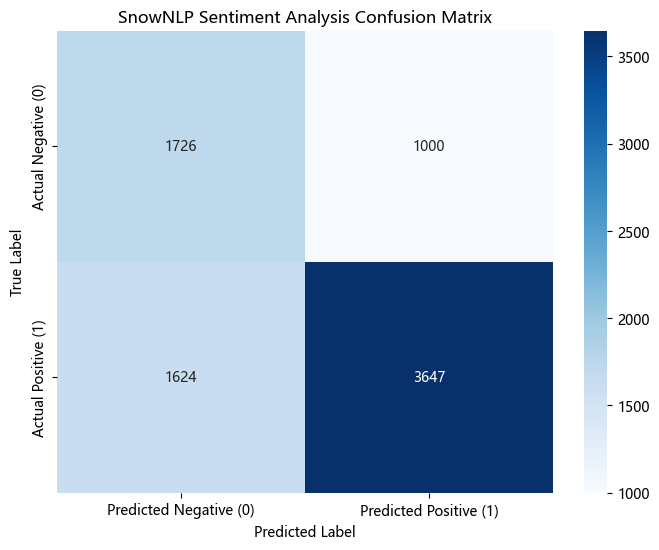

In [13]:
# --- 5. 评估模型 ---
# print("\n--- 评估结果 ---")

# Classification Report
print("Classification Report:")
# zero_division=0 避免在某个类别没有预测样本时产生警告
try:
    report = classification_report(y_test, predictions, target_names=['Negative (0)', 'Positive (1)'], zero_division=0)
    print(report)
except ValueError as e:
    print(f"生成分类报告时出错: {e}")
    print("真实标签:", y_test.unique())
    print("预测标签:", pd.Series(predictions).unique())


# Confusion Matrix
print("\nConfusion Matrix:")
try:
    cm = confusion_matrix(y_test, predictions)
    print(cm)

    # --- 6. 可视化混淆矩阵 ---
    print("\n绘制混淆矩阵...")
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Negative (0)', 'Predicted Positive (1)'],
                yticklabels=['Actual Negative (0)', 'Actual Positive (1)'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('SnowNLP Sentiment Analysis Confusion Matrix')
    # 解决中文显示问题 (如果需要)
    plt.rcParams['font.sans-serif'] = ['Microsoft YaHei'] # 或者其他支持中文的字体如 'Microsoft YaHei'
    plt.rcParams['axes.unicode_minus'] = False # 解决负号显示问题
    plt.show()
except ValueError as e:
    print(f"生成或绘制混淆矩阵时出错: {e}")
    print("真实标签:", y_test.unique())
    print("预测标签:", pd.Series(predictions).unique())